In [14]:
%pip install opencv-python
%pip install matplotlib
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



# Load the Dataset using a Pytorch Data Loader

In [15]:
import os
import cv2
import numpy as np
import random
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Process All Images

- Prepare Images

In [16]:
train_dir = './images/Trains'

image_size = 256

# crop aa square in the center and apply color and weighted guassian blur
def prepare_image(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # get center crop dimensions
    h, w, _ = image.shape
    min_dim = min(h, w)  # get smaller dimension to ensure the crop is square
    start_x = (w - min_dim) // 2  # get starting x-coordinate for the crop
    start_y = (h - min_dim) // 2  # get starting y-coordinate for the crop

    # crop image to a square from the center
    cropped_image = image[start_y:start_y + min_dim, start_x:start_x + min_dim]

    resized_image = cv2.resize(cropped_image, (image_size, image_size))

    # apply weighted Gaussian blur
    blurred_image = cv2.addWeighted(resized_image, 4, cv2.GaussianBlur(resized_image, (0, 0), sigmaX), -4, 128)

    # normalize [0, 1]
    image_tensor = torch.tensor(blurred_image, dtype=torch.float32) / 255.0
    # rearrange to channel-first format
    image_tensor = image_tensor.permute(2, 0, 1) 
    return image_tensor

- Download Images

In [ ]:
train_dir = './images/Tests'
output_dir = './images/test_preprocessed'  # new dir

# create dir
def create_output_dirs():
    for i in range(5):
        sub_dir = os.path.join(output_dir, str(i))
        os.makedirs(sub_dir, exist_ok=True)

# preprocess then save
def transform_and_save_images():
    create_output_dirs()

    # go through the directories (0-4) in the train directory
    for label in range(5):
        input_dir = os.path.join(train_dir, str(label))
        output_subdir = os.path.join(output_dir, str(label))

        # go through all image files in the directory
        for filename in os.listdir(input_dir):
            file_path = os.path.join(input_dir, filename)
            if file_path.endswith(('.jpg', '.png', '.jpeg')):
                # transform
                transformed_image = prepare_image(file_path)

                # convert to pytorch tensor to numpy array
                transformed_image = transformed_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW -> HWC

                # convert to uint8 for saving
                transformed_image = np.clip(transformed_image * 255, 0, 255).astype(np.uint8)

                # save transformed image to output dir
                output_path = os.path.join(output_subdir, filename)
                cv2.imwrite(output_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))

                print(f"Processed and saved: {filename} to {output_path}")

transform_and_save_images()


- Display Images

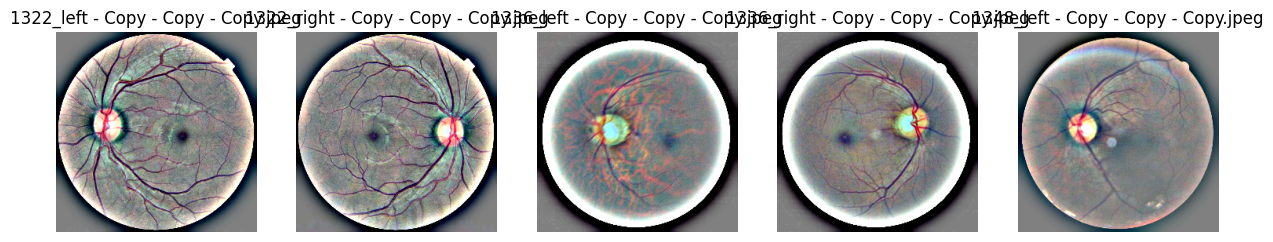

In [ ]:
def visualize_transformed_images(dataset_dir, num_images=5, sigmaX=10):
    # display some transformed images
    images = []
    labels = []
    for i, (root, _, files) in enumerate(os.walk(dataset_dir)):
        for file in files:
            if file.endswith(('.jpeg')):
                image_path = os.path.join(root, file)
                transformed_image = prepare_image(image_path, sigmaX=sigmaX)
                images.append(transformed_image)
                labels.append(file)
                if len(images) >= num_images:
                    break
        if len(images) >= num_images:
            break

    # plot
    plt.figure(figsize=(15, 5))
    for i, img_tensor in enumerate(images):
        # convert back to HWC for display
        img = img_tensor.permute(1, 2, 0).numpy()
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

visualize_transformed_images(train_dir, num_images=5, sigmaX=10)

# Loading the Dataset

In [ ]:
# seed for consistency
torch.manual_seed(42)

BATCH_SIZE = 8
EPOCHS = 19
LEARNING_RATE = 1e-4
NUM_CLASSES = 5
IMAGE_SIZE = (256, 256)


def load_data(train_dir, test_dir, batch_size, img_size):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset.classes

train_dir = './images/train_preprocessed'
test_dir = './images/test_preprocessed'

train_loader, test_loader, class_names = load_data(train_dir, test_dir, BATCH_SIZE, IMAGE_SIZE)

# Defining the Model

In [4]:
class UNetCNN(nn.Module):
    def __init__(self, num_classes):
        super(UNetCNN, self).__init__()

        # downsample
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # upsample
        self.up4 = self.upconv_block(1024, 512)
        self.up3 = self.upconv_block(512, 256)
        self.up2 = self.upconv_block(256, 128)
        self.up1 = self.upconv_block(128, 64)

        # last classification layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, num_classes)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        bottleneck = self.bottleneck(enc4)

        up4 = self.up4(bottleneck) + enc4
        up3 = self.up3(up4) + enc3
        up2 = self.up2(up3) + enc2
        up1 = self.up1(up2) + enc1

        pooled = self.global_pool(up1)
        flattened = self.flatten(pooled)
        logits = self.fc(flattened)

        return logits

# Training the Model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetCNN(num_classes=NUM_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Epoch 1/19, Loss: 1.5643                                                                            
Epoch 2/19, Loss: 1.4557                                                                            
Epoch 3/19, Loss: 1.4150                                                                            
Epoch 4/19, Loss: 1.3643                                                                            
Epoch 5/19, Loss: 1.3365                                                                            
Epoch 6/19, Loss: 1.3166                                                                            
Epoch 7/19, Loss: 1.2933                                                                            
Epoch 8/19, Loss: 1.2779                                                                            
Epoch 9/19, Loss: 1.2552                                                                            
Epoch 10/19, Loss: 1.2407                                                                  

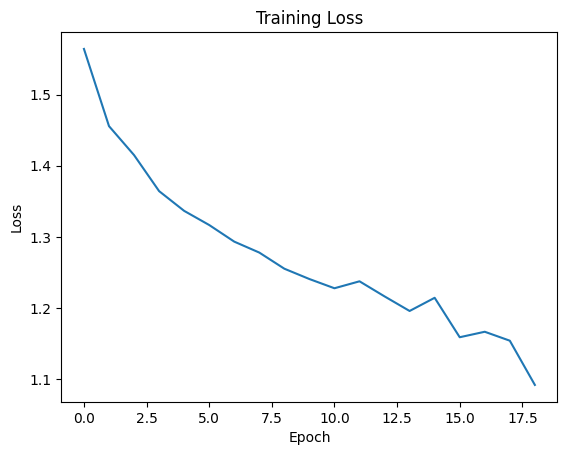

In [6]:
def train_model(model, train_loader, optimizer, loss_fn, epochs, device):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader, start=1):  # Added batch index
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Image {batch_idx}/{len(train_loader)}          ", end="\r")
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f" " * 100, end="\r")
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


train_model(model, train_loader, optimizer, loss_fn, EPOCHS, device)

# Test the Model

In [7]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.extend(outputs.argmax(1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(targets, preds, target_names=class_names))
    
    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average='weighted')
    recall = recall_score(targets, preds, average='weighted')
    f1 = f1_score(targets, preds, average='weighted')

    print("\nEvaluation Metrics:")
    print("-" * 25)
    print(f"{'Accuracy':<15}{accuracy:>10.4f}")
    print(f"{'Precision':<15}{precision:>10.4f}")
    print(f"{'Recall':<15}{recall:>10.4f}")
    print(f"{'F1 Score':<15}{f1:>10.4f}")
    
evaluate_model(model, test_loader, device, class_names)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        26
           1       0.39      0.46      0.42        26
           2       0.33      0.15      0.21        26
           3       0.59      0.77      0.67        26
           4       0.69      0.92      0.79        26

    accuracy                           0.54       130
   macro avg       0.51      0.54      0.51       130
weighted avg       0.51      0.54      0.51       130


Evaluation Metrics:
-------------------------
Accuracy           0.5385
Precision          0.5100
Recall             0.5385
F1 Score           0.5079


In [8]:
# Play sound to notify model training completion
os.system("cutepiano.mp3")

0

# Import to State Dictionary file

In [10]:
torch.save(model.state_dict(), 'Group11-UNET-backup.pth')